# Sentiment Analysis

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import gensim.downloader as api
from gensim.models import KeyedVectors
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

## Load Datasets

In [2]:
test_df = pd.read_csv('test_data.csv')
train_df = pd.read_csv('train_data.csv')
title_brand_df = pd.read_csv('title_brand.csv')

In [3]:
test_df.head()

,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,NaN,True,2018-06-04,A20GGWE66JW9X2,B006Z394GM,{'Color:': ' FPS01-C'},Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...,1528070400
1,NaN,True,2018-02-18,ARYJWXHEYHG9M,B005BE058W,"{'Size:': ' 1000W', 'Style:': ' G2'}",Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR,1518912000
2,NaN,True,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,NaN,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular,1516406400
3,NaN,True,2018-06-25,A11VN8EOHNLP72,B00FBJ4KYC,NaN,Jeremy Bray,I purchased this 4 year protection plan for a ...,DO NOT BUY!!!,1529884800
4,3.0,True,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,NaN,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy,1471392000


In [4]:
train_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,2,NaN,False,2016-11-11,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,1478822400
1,5,NaN,True,2016-06-06,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1465171200
2,4,NaN,True,2016-03-10,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1457568000
3,5,NaN,True,2016-01-14,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600
4,5,NaN,True,2016-10-20,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1476921600


In [5]:
title_brand_df.head()

,asin,title,brand
0,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision
1,0043396828,"Books ""Handbook of Astronomical Image Processi...",33 Books Co.
2,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page
3,0060219602,Hurray for Hattie Rabbit: Story and pictures (...,Visit Amazon's Dick Gackenbach Page
4,0060786817,sex.lies.murder.fame.: A Novel,Visit Amazon's Lolita Files Page


# Exploratory Data Analysis

## 1. Distribution of Overall Ratings

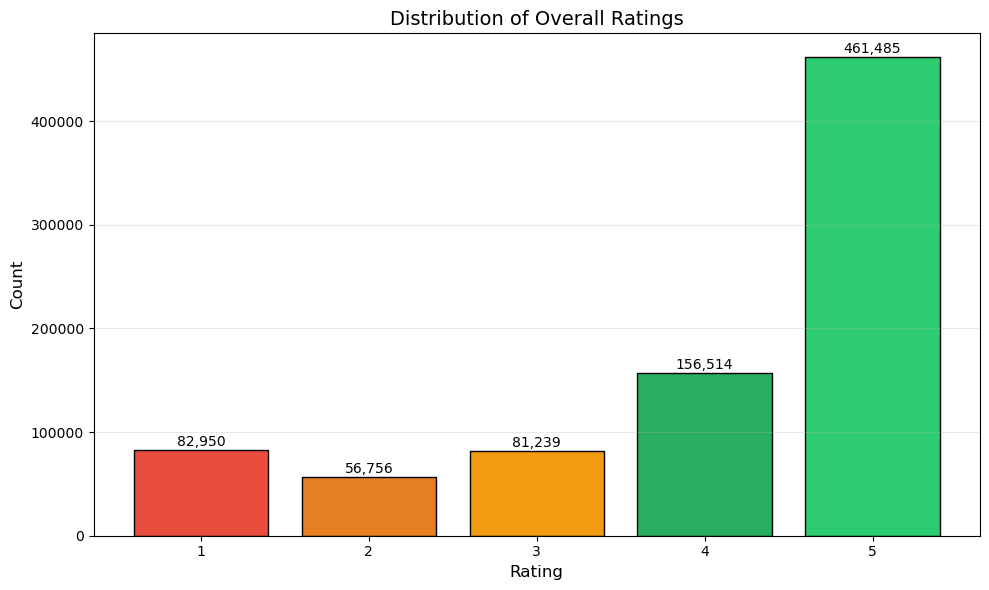

Percentage Distribution:

overall
1     9.887430
2     6.765171
3     9.683483
4    18.656072
5    55.007843
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(10, 6))
overall_counts = train_df['overall'].value_counts().sort_index()
colors = ['#e74c3c', '#e67e22', '#f39c12', '#27ae60', '#2ecc71']
bars = plt.bar(overall_counts.index, overall_counts.values, color=colors, edgecolor='black')

for bar, count in zip(bars, overall_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Overall Ratings', fontsize=14)
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

rating_dist = train_df['overall'].value_counts(normalize=True) * 100
print("Percentage Distribution:\n")
print(rating_dist.sort_index())

### Is the Dataset Balanced?

No, the dataset is clearly **imbalanced**.
More than half of the reviews (55.01%) belong to rating **5**, while rating **2** represents only 6.77% of the data. The majority class (rating 5) has over **8 times** more samples than the minority class (rating 2), as indicated by the imbalance ratio of **8.13**.
This confirms a significant class imbalance problem.


### Should the Dataset Be Balanced for Modeling?
Yes — especially if the task is a **5-class classification problem** (predicting ratings from 1 to 5).

If no action is taken:
- The model may become biased toward predicting rating 5.
- Accuracy may appear high.
- Performance on minority classes (1 and 2) may be poor.
- Recall and F1-score for minority classes may significantly drop.

If the problem is converted into a 3-class sentiment classification (negative, neutral, positive), the imbalance may decrease, but the positive class will likely still dominate.

### Recommended Solution
The most appropriate and academically sound approach is:

### Use Class Weights
Instead of modifying the dataset, assign higher weights to minority classes during training.

## 2. Word Clouds (Positive / Neutral / Negative)

To better understand the textual patterns in the dataset, reviews are going to be grouped into three sentiment categories based on their rating:

- Positive: ratings 4 and 5
- Neutral: rating 3
- Negative: ratings 1 and 2

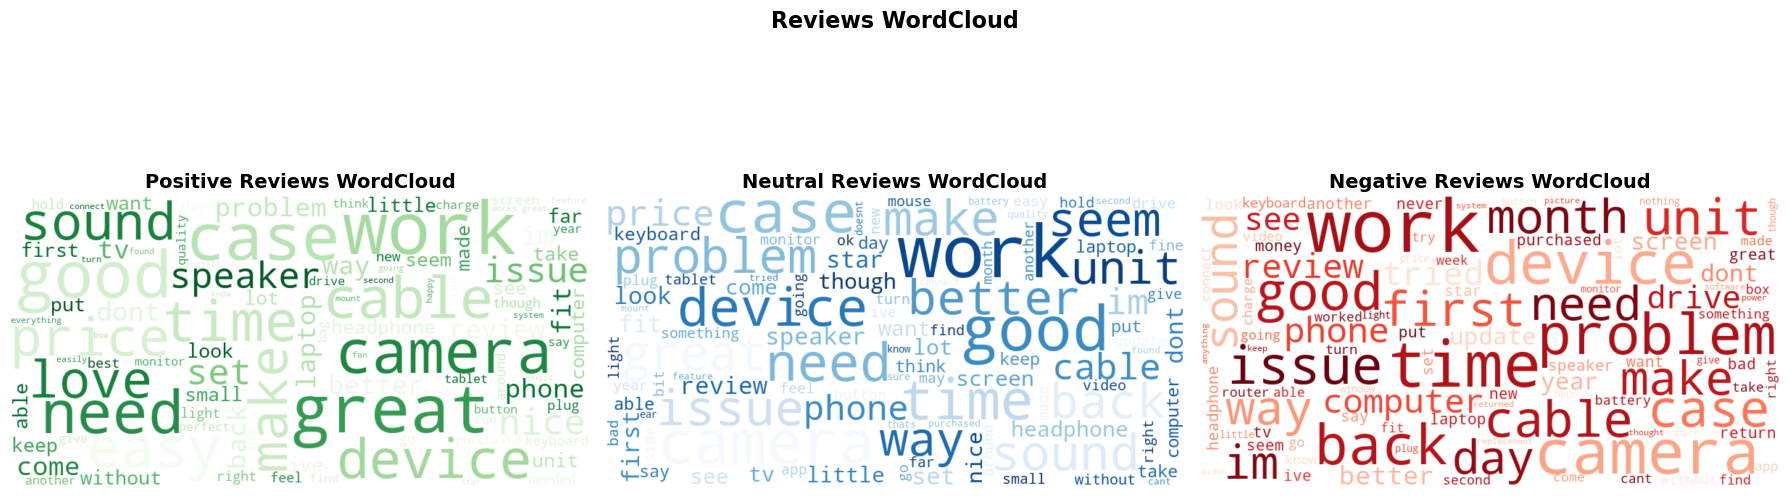

In [7]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# categorize sentiment (positive, neutral, negative)
def categorize_sentiment(overall):
    if overall >= 4:
        return 'positive'
    elif overall == 3:
        return 'neutral'
    else:
        return 'negative'

train_df['sentiment'] = train_df['overall'].apply(categorize_sentiment)

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)         # Links removal
    text = re.sub(r'[^a-zA-Z\s]', '', text)     # Punctuations removal
    text = re.sub(r'\s+', ' ', text).strip()    # Spaces handling
    return text

# stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords.words('english'))
custom_stopwords.update(['one', 'two', 'would', 'could', 'also', 'get', 'got',
                          'use', 'used', 'using', 'thing', 'things', 'really',
                          'even', 'much', 'well', 'still', 'just', 'like',
                          'amazon', 'product', 'item', 'buy', 'bought', 'purchase',
                          'ordered', 'order', 'received', 'came', 'arrived'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# wordcloud + plot
sentiments = ['positive', 'neutral', 'negative']
colors = ['Greens', 'Blues', 'Reds']

for idx, (sentiment, colormap) in enumerate(zip(sentiments, colors)):
    texts = train_df[train_df['sentiment'] == sentiment]['reviewText'].dropna()

    sample_size = min(50000, len(texts))
    combined_text = ' '.join(texts.sample(sample_size, random_state=42).apply(clean_text))

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords,
        max_words=100,
        colormap=colormap,
        min_font_size=10,
        max_font_size=100
    ).generate(combined_text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f"{sentiment.capitalize()} Reviews WordCloud", fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Reviews WordCloud', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Common Words Between Positive and Negative Reviews

In [8]:
def get_top_words(texts, n=50):
    all_words = []
    for text in texts.dropna().sample(min(30000, len(texts)), random_state=42):
        cleaned = clean_text(text)
        words = [w for w in cleaned.split() if w not in custom_stopwords and len(w) > 2]
        all_words.extend(words)
    return Counter(all_words).most_common(n)

positive_words = set([w[0] for w in get_top_words(train_df[train_df['sentiment'] == 'positive']['reviewText'])])
negative_words = set([w[0] for w in get_top_words(train_df[train_df['sentiment'] == 'negative']['reviewText'])])
common_words = positive_words.intersection(negative_words)

print(f"{len(common_words)} Common Words")
print(list(common_words)[:20])

29 Common Words
['screen', 'good', 'phone', 'work', 'see', 'make', 'works', 'quality', 'right', 'cable', 'case', 'great', 'sound', 'battery', 'way', 'back', 'first', 'ive', 'better', 'usb']


### Interpretation

The common words shared between positive and negative reviews typically include:

1. Product and brand names (e.g., cable, battery, phone, etc.)
2. General descriptive words (e.g., quality, price, time)
3. Performance-related words (e.g., work, works, working)

These words appear in both sentiment categories because their polarity depends on context:

- In positive reviews:  
  - "great quality"  
  - "works perfectly"

- In negative reviews:  
  - "poor quality"  
  - "doesn't work"

Therefore, context and surrounding words are more important than the individual word itself in determining sentiment.

## 3. Top 10 Reviewers by Total Helpful Votes

In [9]:
train_df["vote"] = pd.to_numeric(train_df["vote"], errors="coerce").fillna(0)
train_df['vote'] = train_df['vote'].astype(str).str.replace(',', '')
train_df['vote'] = train_df['vote'].astype(float).astype(int)

top_reviewers = (
    train_df
    .groupby(["reviewerID", "reviewerName"], as_index=False)["vote"]
    .sum()
    .sort_values("vote", ascending=False)
    .head(10)
)
top_reviewers = top_reviewers.rename(columns={
    "reviewerID": "Reviewer ID",
    "reviewerName": "Reviewer Name",
    "vote": "Total Helpful Votes"
})
top_reviewers.index = range(1, len(top_reviewers) + 1)

print("\nTop 10 Reviewers by Total Helpful Votes\n")
display(top_reviewers)


Top 10 Reviewers by Total Helpful Votes



,Reviewer ID,Reviewer Name,Total Helpful Votes
1,A25GROL6KJV3QG,Benson Leung,4572
2,A2IK776FY6MEMG,Obi Wan,1608
3,A1A39899KH5QCI,Chris Winter,1352
4,AMYCUX8EWEUVV,Mayra S.,1342
5,A9K7V1MKJ9BOJ,VermontGuy,1337
6,A1UQUDT2Q0YENM,Michael,1230
7,A3R1WFO4KIUQXZ,PhotoGraphics,1209
8,A2Z9APP5B09MFY,Nicholas,1188
9,AOEAD7DPLZE53,NLee the Engineer,1103
10,AZPCDY9OQ605E,David H,1045


## 4. Histogram of Review Length

In [10]:
train_df['review_length'] = train_df['reviewText'].fillna('').apply(len)
train_df['review_length'].describe()

count    838944.000000
mean        624.687384
std         684.129474
min         200.000000
25%         277.000000
50%         408.000000
75%         697.000000
max       29146.000000
Name: review_length, dtype: float64

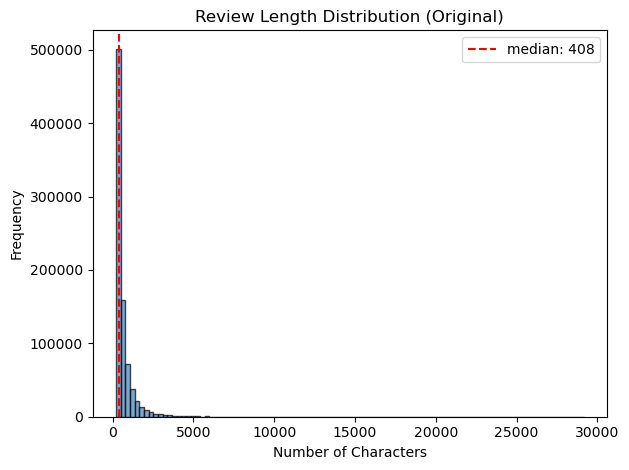

In [11]:
# original histogram
plt.hist(train_df['review_length'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Review Length Distribution (Original)')
plt.axvline(train_df['review_length'].median(), color='red', linestyle='--', label=f'median: {train_df["review_length"].median():.0f}')
plt.legend()

plt.tight_layout()
plt.show()

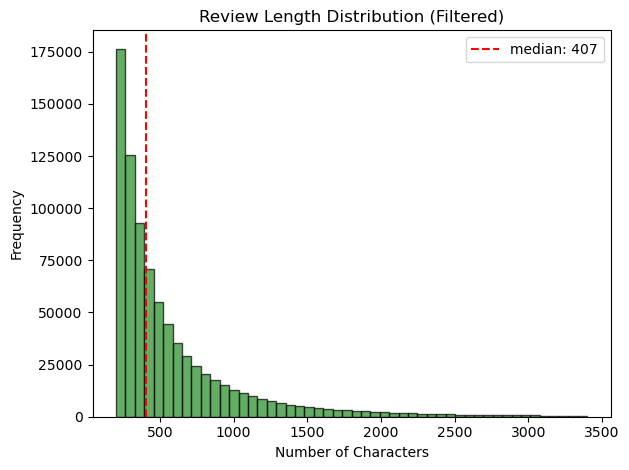

In [12]:
#filtered histogram (remove outliers)
lower_bound = train_df['review_length'].quantile(0.01)
upper_bound = train_df['review_length'].quantile(0.99)
filtered_df = train_df[(train_df['review_length'] >= lower_bound) & (train_df['review_length'] <= upper_bound)]

plt.hist(filtered_df['review_length'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Review Length Distribution (Filtered)')
plt.axvline(filtered_df['review_length'].median(), color='red', linestyle='--', label=f'median: {filtered_df["review_length"].median():.0f}')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Descriptive statistics
print("Descriptive Statistics of Review Text Length:")
print("=" * 50)
print(f"Minimum: {train_df['review_length'].min():,}")
print(f"Maximum: {train_df['review_length'].max():,}")
print(f"Mean: {train_df['review_length'].mean():,.2f}")
print(f"Median: {train_df['review_length'].median():,.0f}")
print(f"Standard Deviation: {train_df['review_length'].std():,.2f}")

print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {train_df['review_length'].quantile(p/100):,.0f}")

Descriptive Statistics of Review Text Length:
Minimum: 200
Maximum: 29,146
Mean: 624.69
Median: 408
Standard Deviation: 684.13

Percentiles:
  25th percentile: 277
  50th percentile: 408
  75th percentile: 697
  90th percentile: 1,217
  95th percentile: 1,733
  99th percentile: 3,399


### Suggested Text Length Limits for Modeling

Based on the data distribution:

- **Minimum suggested length:** 10 characters (to remove extremely short and non-informative reviews)
- **Maximum suggested length:** 2000–3000 characters (approximately the 95th–99th percentile)

#### Reasons:

1. Very short reviews usually do not contain enough useful information.
2. Extremely long reviews may include redundant details and consume excessive memory.
3. Transformer-based models typically have a limit of 512 tokens.

#### Recommended Range: [10, 2500] characters

## 5. Top 10 Products with Most 5-Star Reviews

In [14]:
five_star_reviews = train_df[train_df['overall'] == 5]
product_five_stars = five_star_reviews.groupby('asin').size().reset_index(name='five_star_count')
top_10_products = product_five_stars.nlargest(10, 'five_star_count')
top_10_products = top_10_products.merge(title_brand_df, on='asin', how='left')

# result
result_df = top_10_products[['brand', 'title', 'five_star_count']].copy()
result_df.columns = ['Brand', 'Product Title', 'Number of 5-Star Ratings']
result_df.index = range(1, len(result_df) + 1)
print("Top 10 Products with the Highest Number of 5-Star Ratings:\n")
display(result_df)

Top 10 Products with the Highest Number of 5-Star Ratings:



,Brand,Product Title,Number of 5-Star Ratings
1,Cambridge Soundworks,OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...,1163
2,NETGEAR,NETGEAR N300 WiFi Range Extender (EX2700),659
3,Roku,Roku Streaming Stick (3600R) - HD Streaming Pl...,600
4,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...,598
5,Logitech,Logitech M570 Wireless Trackball Mouse &ndash;...,552
6,Samsung,Samsung 850 EVO 500GB 2.5-Inch SATA III Intern...,529
7,Asus,ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...,471
8,VideoSecu,VideoSecu ML531BE TV Wall Mount for Most 27&qu...,448
9,"Arlo Technologies, Inc",Arlo - Wireless Home Security Camera System | ...,433
10,Samsung,Samsung 850 EVO 250GB 2.5-Inch SATA III Intern...,431


## 6. Top 10 Brands by Number of Reviews + Average Rating

In [15]:
# Merge brand information
train_with_brand = train_df.merge(title_brand_df[['asin', 'brand']], on='asin', how='left')

# Count reviews per brand
brand_review_counts = train_with_brand.groupby('brand').size().reset_index(name='review_count')

# Select top 10 brands by review count
top_10_brands = brand_review_counts.nlargest(10, 'review_count')['brand'].tolist()

# Compute average rating and total reviews for top brands
brand_stats = train_with_brand[train_with_brand['brand'].isin(top_10_brands)].groupby('brand').agg({
    'overall': 'mean',
    'reviewText': 'count'
}).reset_index()


brand_stats.columns = ['Brand', 'Average Rating', 'Number of Reviews']
brand_stats = brand_stats.sort_values('Average Rating', ascending=False)
brand_stats.index = range(1, len(brand_stats) + 1)

print("Top 10 Brands with the Highest Number of Reviews (Sorted by Average Rating):\n")
display(brand_stats)

Top 10 Brands with the Highest Number of Reviews (Sorted by Average Rating):



,Brand,Average Rating,Number of Reviews
1,Anker,4.244320,9860
2,AmazonBasics,4.201468,13213
3,Sabrent,4.028005,7320
4,SanDisk,3.958810,8400
5,Logitech,3.954061,17066
6,Samsung,3.941268,15409
7,Sony,3.938726,12436
8,TP-LINK,3.928681,9773
9,Asus,3.855550,11928
10,NETGEAR,3.836274,7085


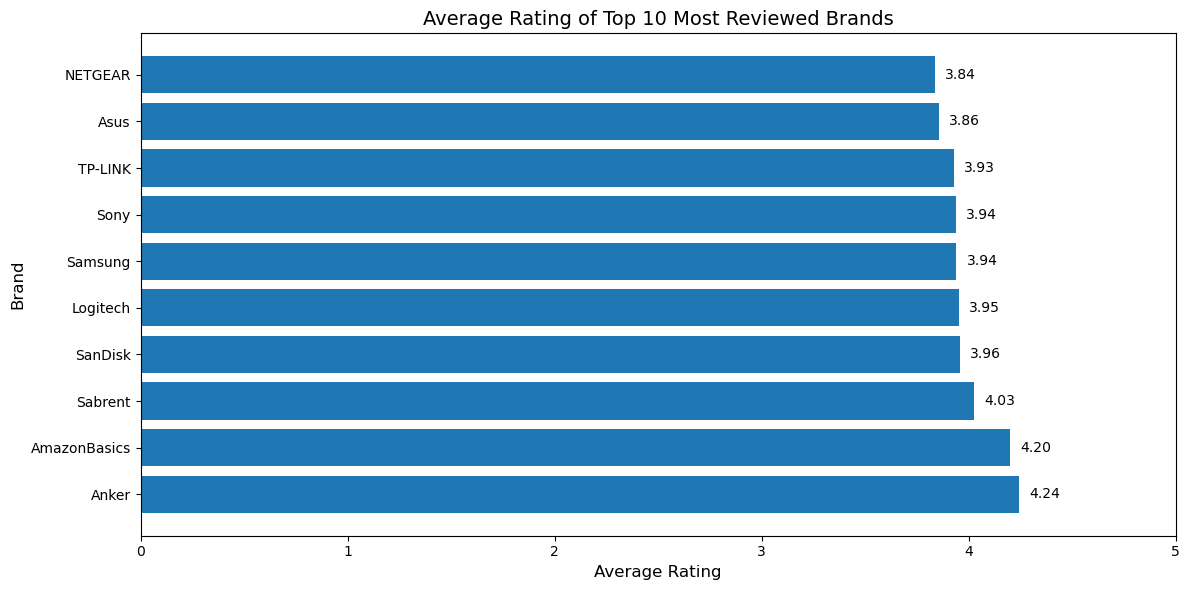

In [16]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(
    brand_stats['Brand'],
    brand_stats['Average Rating']
)

ax.set_xlabel('Average Rating', fontsize=12)
ax.set_ylabel('Brand', fontsize=12)
ax.set_title('Average Rating of Top 10 Most Reviewed Brands', fontsize=14)
ax.set_xlim(0, 5)

for bar, val in zip(bars, brand_stats['Average Rating']):
    ax.text(
        val + 0.05,
        bar.get_y() + bar.get_height()/2,
        f'{val:.2f}',
        va='center'
    )

plt.tight_layout()
plt.show()

# Aspect-Based Satisfaction Analysis: Warranty

## Objective

The goal of this section is to estimate customer satisfaction regarding the warranty aspect of products.

Instead of analyzing all reviews, we focus only on reviews that explicitly discuss warranty-related topics (e.g., warranty, guarantee, coverage, etc.). After identifying such reviews, we compute the average rating (overall) per product based only on those filtered reviews.

This provides an approximation of how satisfied customers are with the warranty of each product.

---

## Problem with Simple Keyword Matching

A naive approach would be to search only for exact words like:

- "warranty"
- "guarantee"

However, this approach is insufficient because:

1. Users may use synonyms (e.g., coverage, protection plan).
2. Users may make spelling mistakes (e.g., warrenty, garantee).
3. Contextual variations may exist.

---

## Proposed Solution

To improve coverage, we:

1. Use word embeddings (e.g., Word2Vec or pre-trained embeddings) to find words semantically similar to:
   - "warranty"
   - "guarantee"

2. Manually include common misspellings.

3. Create an extended keyword list including:
   - Original keywords
   - Similar words from embeddings
   - Common spelling mistakes

4. Filter reviews that contain at least one of these words.

5. Compute the average rating (`overall`) per product using only the filtered reviews.


### Step 1: Load Pretrained Word2Vec Model

In [17]:
word2vec_model = api.load('glove-twitter-100')

### Step 2: Find Similar Words

In [18]:
def get_similar_words(model, words, topn=20):
    similar_words = set()
    for word in words:
        try:
            similars = model.most_similar(word, topn=topn)
            for sim_word, score in similars:
                if score > 0.5:
                    similar_words.add(sim_word.lower())
        except KeyError:
            print(f"{word} Not Found")
    return similar_words

target_words = ['warranty', 'guarantee', 'Warranty', 'Guarantee']
similar_words = get_similar_words(word2vec_model, target_words)
misspellings = {
    'waranty', 'warenty', 'warrenty', 'warrantee', 'warrantie', 'warranties',
    'guarante', 'garantee', 'guarentee', 'gaurantee', 'guaranty', 'guarantees',
    'guarranty', 'warrranty'
}
all_warranty_words = similar_words.union(misspellings).union({'warranty', 'guarantee', 'warranties', 'guarantees'})

print(f"Number of keywords: {len(all_warranty_words)}")
print("Final keyword list:")
print(sorted(all_warranty_words))

Warranty Not Found
Guarantee Not Found
Number of keywords: 53
Final keyword list:
['afford', 'case', 'cord', 'cost', 'doubt', 'earn', 'extended', 'extension', 'external', 'fixed', 'garantee', 'gaurantee', 'guarante', 'guarantee', 'guaranteed', 'guarantees', 'guaranty', 'guarentee', 'guarranty', 'handset', 'however', 'includes', 'insurance', 'knowing', 'licence', 'license', 'lifetime', 'manufacturer', 'offer', 'option', 'otherwise', 'package', 'passport', 'pay', 'payment', 'payments', 'pouch', 'priority', 'replacement', 'subscription', 'surely', 'unless', 'value', 'waranty', 'warenty', 'warrantee', 'warrantie', 'warranties', 'warranty', 'warrenty', 'warrranty', 'worth', 'youll']


### Step 3: Filter Reviews Containing Warranty-Related Words

In [19]:
def contains_warranty_words(text, warranty_words):
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    for word in warranty_words:
        if word.lower() in text_lower:
            return True
    return False

train_df['has_warranty_mention'] = train_df['reviewText'].apply(
    lambda x: contains_warranty_words(x, all_warranty_words)
)

warranty_reviews = train_df[train_df['has_warranty_mention']]

print(f"Number of all Reviews: {len(train_df):,}")
print(f"Number of warranty-related reviews: {len(warranty_reviews):,}")
print(f"Percentage of warranty-related reviews: {len(warranty_reviews)/len(train_df)*100:.2f}%")

Number of all Reviews: 838,944
Number of warranty-related reviews: 405,200
Percentage of warranty-related reviews: 48.30%


In [20]:
warranty_product_stats = (
    warranty_reviews
    .groupby("asin")["overall"]
    .mean()
    .reset_index()
    .rename(columns={"overall": "average_warranty_rating"})
)

# Sort descending
warranty_product_stats = warranty_product_stats.sort_values(
    "average_warranty_rating",
    ascending=False
)

warranty_product_stats.index = range(1, len(warranty_product_stats) + 1)

display(warranty_product_stats.head(10))

,asin,average_warranty_rating
1,B01HJH42KU,5.0
2,B013WZQTNQ,5.0
3,B013WXKIDK,5.0
4,B00CAYF50E,5.0
5,B013WXKMYK,5.0
6,B00CAXFH8A,5.0
7,B013WXKSBM,5.0
8,B00CAX6A3G,5.0
9,B00CAWLUWI,5.0
10,B00CAVG4JS,5.0


### Step 4: Compute Average Rating per Product

In [21]:
warranty_product_ratings = warranty_reviews.groupby('asin').agg({
    'overall': ['mean', 'count']
}).reset_index()
warranty_product_ratings.columns = ['asin', 'warranty_avg_rating', 'warranty_review_count']
warranty_product_ratings = warranty_product_ratings.merge(title_brand_df, on='asin', how='left')

# Only products with at least 5 warranty-related reviews
warranty_product_ratings = warranty_product_ratings[warranty_product_ratings['warranty_review_count'] >= 5]
warranty_product_ratings = warranty_product_ratings.sort_values('warranty_avg_rating', ascending=False)

result_df = warranty_product_ratings[
    ['brand', 'title', 'warranty_avg_rating', 'warranty_review_count']
].copy()
result_df.columns = [
    'Brand',
    'Product Title',
    'Average Warranty Rating',
    'Number of Warranty Reviews'
]
result_df.index = range(1, len(result_df) + 1)

print("Average Warranty Satisfaction Ratings (Products with ≥5 Warranty Reviews):\n")
display(result_df.head(20))

# Save results
result_df.to_csv('../outputs/warranty_satisfaction_ratings.csv', index=False)
print("Results saved to 'warranty_satisfaction_ratings.csv'.")

Average Warranty Satisfaction Ratings (Products with ≥5 Warranty Reviews):



,Brand,Product Title,Average Warranty Rating,Number of Warranty Reviews
1,DVRdaddy,6TB DVRdaddy External DVR Hard Drive Expander ...,5.0,7
2,iKits,"iKits Short Micro USB Cable, 0.5ft Nylon Braid...",5.0,11
3,Intermatic,Intermatic&nbsp;Smart Guard&nbsp;IG2240-IMSK&n...,5.0,6
4,SMTPP,"TWS Bluetooth Speaker,Portable Wireless Speake...",5.0,8
5,A-Tech Components,A-Tech For Apple 4GB Module PC3-8500 Mac mini ...,5.0,5
6,Tenba,Tenba TTP34 Car Case TriPak (634-508),5.0,6
7,Tenba,Tenba TTP34 Car Case TriPak (634-508),5.0,6
8,Cryorig,Cryorig QF120 Performance 120mm PWM Fan 600-22...,5.0,5
9,LeeKooLuu,LeeKooLuu Backup Camera and 7&quot; Monitor Sy...,5.0,8
10,APC,APC LE1200 Line-R 1200VA Automatic Voltage Reg...,5.0,6


Results saved to 'warranty_satisfaction_ratings.csv'.


### Step 5: Overall Warranty Satisfaction Analysis

Average rating of warranty-related reviews: 3.99


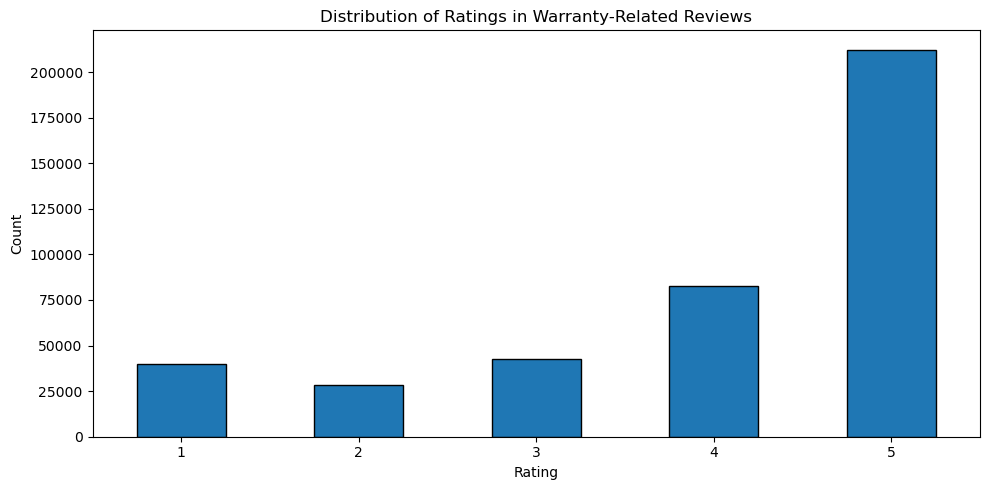

In [22]:
print(f"Average rating of warranty-related reviews: {warranty_reviews['overall'].mean():.2f}")

# Distribution of ratings for warranty-related reviews
plt.figure(figsize=(10, 5))

warranty_reviews['overall'].value_counts().sort_index().plot(kind='bar', edgecolor='black')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Warranty-Related Reviews')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Sentiment Analysis Model

## Objective

In this section, we aim to build a supervised sentiment analysis model that predicts a user's satisfaction score (from 1 to 5) based on the review text.

The target variable is:
- `overall` (integer rating from 1 to 5)

The main input feature is:
- `reviewText`

Optionally, additional features can be incorporated. However, the primary input is the review text.

---

## Problem Type

This is a multi-class classification problem with 5 classes:
- Class 1 → Very Negative
- Class 2 → Negative
- Class 3 → Neutral
- Class 4 → Positive
- Class 5 → Very Positive

---

## Model Choice

For this task, we use a **pre-trained Transformer model (BERT)** and fine-tune it on our dataset.

### Step 1: Preprocess

In [23]:
# text preprocess
def preprocess_text(text, summary=None):
    if pd.isna(text):
        text = ""
    else:
        text = str(text)

    # summary
    if summary and not pd.isna(summary):
        text = f"{summary}. {text}"

    # clean text
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

train_df['processed_text'] = train_df.apply(
    lambda row: preprocess_text(row['reviewText'], row['summary']), axis=1
)

train_df = train_df[train_df['processed_text'].str.len() > 10]
train_df['label'] = train_df['overall'] - 1

### Step 2: Sampling to reduce dataset size (for resource limitations)

In [24]:
SAMPLE_SIZE = 150000

if len(train_df) > SAMPLE_SIZE:
    # Stratified Sampling
    train_sample = train_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), SAMPLE_SIZE // 5), random_state=42)
    )
else:
    train_sample = train_df

print(f"Number of selected samples: {len(train_sample):,}")
print("\nLabel distribution:")
print(train_sample['label'].value_counts().sort_index())

Number of selected samples: 150,000

Label distribution:
label
0    30000
1    30000
2    30000
3    30000
4    30000
Name: count, dtype: int64


### Step 3: Train-validation split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    train_sample['processed_text'].values,
    train_sample['label'].values,
    test_size=0.15,
    random_state=42,
    stratify=train_sample['label'].values
)

print(f"Number of training samples: {len(X_train):,}")
print(f"Number of validation samples: {len(X_val):,}")

Number of training samples: 127,500
Number of validation samples: 22,500


### Step 4: Model Selection

In [26]:
MODEL_NAME = "distilbert-base-uncased" # or "bert-base-uncased", "roberta-base"

### Step 5: Tokenizer Loading

In [27]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Step 6: Dataset Definition

In [28]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

### Step 7: Creating Datasets

In [29]:
train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_length=128)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, max_length=128)

### Step 8: Computing Class Weights

In [30]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("class weights:", class_weights)

class weights: tensor([1., 1., 1., 1., 1.])


As the dataset is balanced we use the original trainer rather than the weigthed one.

### Step 9: Load Model

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=5,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True 
)

# Move to GPU if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")
    print("Using CPU")

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1976.87it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Using Apple GPU (MPS)


### Step 10: Metrics Computation

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1_micro = f1_score(labels, predictions, average='micro')
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

### Step 11: Training Configuration

In [33]:
total_steps = len(train_dataset) * 4 // 16 
warmup_steps = int(0.1 * total_steps)

training_args = TrainingArguments(
    output_dir='./sentiment_model',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=warmup_steps,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='f1_micro',
    greater_is_better=True,
    learning_rate=2e-5,
    fp16=False,
    dataloader_num_workers=0,
    gradient_accumulation_steps=2,
    save_total_limit=2,
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


### Step 12: Trainer Initialization

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

### Step 13: Training

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted
500,2.839709,1.336106,0.439467,0.383983,0.383983
1000,2.254470,1.089587,0.530711,0.513185,0.513185
1500,2.117509,1.025788,0.554889,0.544880,0.544880
2000,2.083314,1.009752,0.560844,0.561327,0.561327
2500,2.089819,1.059751,0.541244,0.540955,0.540955
3000,1.978293,0.960876,0.583200,0.578898,0.578898
3500,1.938333,0.948792,0.585333,0.582402,0.582402
4000,1.867105,0.947147,0.590622,0.581731,0.581731
4500,1.804222,0.924084,0.601244,0.595796,0.595796
5000,1.848505,0.926964,0.605600,0.593634,0.593634


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted
500,2.839709,1.336106,0.439467,0.383983,0.383983
1000,2.254470,1.089587,0.530711,0.513185,0.513185
1500,2.117509,1.025788,0.554889,0.544880,0.544880
2000,2.083314,1.009752,0.560844,0.561327,0.561327
2500,2.089819,1.059751,0.541244,0.540955,0.540955
3000,1.978293,0.960876,0.583200,0.578898,0.578898
3500,1.938333,0.948792,0.585333,0.582402,0.582402
4000,1.867105,0.947147,0.590622,0.581731,0.581731
4500,1.804222,0.924084,0.601244,0.595796,0.595796
5000,1.848505,0.926964,0.605600,0.593634,0.593634


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=15938, training_loss=1.8026334193169, metrics={'train_runtime': 7195.3227, 'train_samples_per_second': 35.44, 'train_steps_per_second': 2.215, 'total_flos': 8445248467200000.0, 'train_loss': 1.8026334193169, 'epoch': 2.0})

### Step 15: Model Evaluation and Performance Analysis

Model evaluation on validation data:


{'eval_loss': 0.8508002758026123, 'eval_f1_micro': 0.6412, 'eval_f1_macro': 0.6396767608097659, 'eval_f1_weighted': 0.6396767608097659, 'eval_runtime': 100.7076, 'eval_samples_per_second': 223.419, 'eval_steps_per_second': 13.971, 'epoch': 2.0}
Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.72      0.71      4500
           2       0.53      0.54      0.53      4500
           3       0.57      0.56      0.57      4500
           4       0.63      0.58      0.60      4500
           5       0.76      0.81      0.78      4500

    accuracy                           0.64     22500
   macro avg       0.64      0.64      0.64     22500
weighted avg       0.64      0.64      0.64     22500



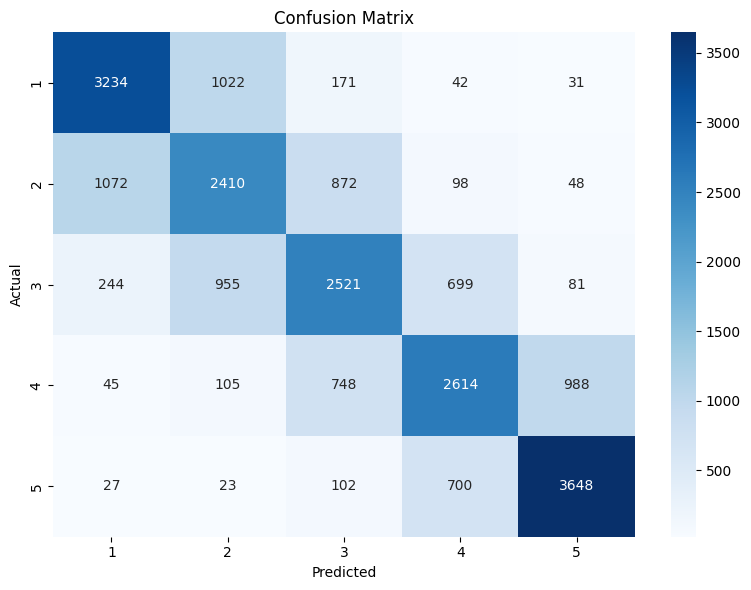

In [ ]:
# Evaluation on validation data
print("Model evaluation on validation data:")
eval_results = trainer.evaluate()
print(eval_results)

# Prediction on validation data
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_val, pred_labels, target_names=['1', '2', '3', '4', '5']))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Step 16: Test data preprocessing

In [ ]:
test_df['processed_text'] = test_df.apply(
    lambda row: preprocess_text(row['reviewText'], row['summary']), axis=1
)

class TestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

test_dataset = TestDataset(test_df['processed_text'].values, tokenizer)

In [ ]:
test_predictions = trainer.predict(test_dataset)
test_pred_labels = np.argmax(test_predictions.predictions, axis=1)

test_pred_labels = test_pred_labels + 1

print(pd.Series(test_pred_labels).value_counts().sort_index())

1    4158
2    3991
3    4050
4    3845
5    3956
Name: count, dtype: int64


In [ ]:
submission = pd.DataFrame({'predicted': test_pred_labels})
submission.to_csv('../outputs/q2_submission.csv', index=False, encoding='utf-8-sig')